In this notebook, I want to introduce you to the Tensorflow layers section. Particularly, those layers which are used for NLP tasks. My goal is to demistify for you what is happening inside these layers when they receive and process data encapsulated into flowing tensors.

## Layers 

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential

tf.get_logger().setLevel('ERROR')

In [2]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 5000

def load_and_preprocess_imdb(vocab_size=5000, maxlen=100):
    """
    Load the IMDB dataset and preprocess it.
    
    Parameters:
    - vocab_size: Maximum number of words to consider from the dataset.
    - maxlen: Maximum length for each sequence after padding.
    
    Returns:
    - x_train: Padded training sequences.
    - y_train: Training labels.
    """

    (x_train, y_train), _ = imdb.load_data(num_words=vocab_size, maxlen=maxlen)

    print(f"Input sample (shortened to 10 word indices): {x_train[0][:10]}")
    print(f"Corresponding sentiment class: {y_train[0]}")

    print(f"Shape before padding: {x_train.shape}")
    x_train = pad_sequences(x_train, maxlen=maxlen)
    print(f"Shape after padding: {x_train.shape}")
    
    return x_train, y_train

### Embedding

The Embedding layer is like a look up table. It learns weights, where each weight row in the matrix is a learned word vecotr, aka. word embedding, associated with a respective input element.

In [4]:
import numpy as np
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential

In [5]:
vector_array = np.array([
    [3, 2]  # indexes of words in the vocabulary. For example "hi there". 2 words, 2 indexes, a vector of 2 elements.
])

model = Sequential()
embedding_layer = Embedding(
    input_dim=10, # the number of words in the vocabulary
    output_dim=4, # the number of abstract dimensions
    input_length=2  # the length of input sequences
)
model.add(embedding_layer)
model.compile('adam', 'mse')

output_array = model.predict(vector_array)

1/1 [==============================] - 0s 27ms/step


In [6]:
print(f"Input shape: {vector_array.shape}")
print("Output of the Embedding layer:")
print(output_array)

Input shape: (1, 2)
Output of the Embedding layer:
[[[-0.04408998 -0.00285099  0.02676551  0.02378443]
  [-0.00211839 -0.02200176  0.01337815 -0.02798291]]]


The output of the Embedding layer represents those rows from the weight matrix, that correspond to the input values.

In this case, for the input [3, 2], which are indexes of words in the vocabulary representing the sentence "hi there", the Embedding layer outputed those words embeddings (vectors) for those indexes, hence for words "hi there".

Let's take a look at the weight matrix.

In [7]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2, 4)              40        
                                                                 
Total params: 40 (160.00 Byte)
Trainable params: 40 (160.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Here, in the output shape we can see output shape as (2, 4). 2 corresponds to the input length (which is a vector length), and 4 which is the number of dimentions the layer has learned to associate with [3, 2], hence with ["hi", "there"].

Why the output for one input has 2 rows and 4 columns? Because each word in that sentence is learned to be associated with 4 arbitrary features. The layer learns embeddings for each input index, hence for each input word.

In [8]:
weights = np.array(embedding_layer.get_weights())  
weights

array([[[ 0.024755  ,  0.02903316,  0.01012889,  0.03686501],
        [ 0.04325745,  0.0057205 ,  0.04287637, -0.00876547],
        [-0.00211839, -0.02200176,  0.01337815, -0.02798291],
        [-0.04408998, -0.00285099,  0.02676551,  0.02378443],
        [-0.00346694,  0.04218047,  0.02572289, -0.03348211],
        [ 0.03057535, -0.03344853, -0.01542779,  0.04807935],
        [-0.01871712, -0.04070105, -0.03756765, -0.003783  ],
        [-0.01139668,  0.04783167, -0.0216019 , -0.0422412 ],
        [-0.03717434, -0.04472036, -0.03151283,  0.03082548],
        [-0.03596268,  0.00909228,  0.00074505,  0.00688132]]],
      dtype=float32)

Here, you can see that for the inputs 3 and 2, we got:

[-0.04408998, -0.00285099,  0.02676551,  0.02378443] </br>
[-0.00211839, -0.02200176,  0.01337815, -0.02798291]

which correspond to the vector [3, 2], hence ["hi", "there"]. Which is what you saw in the Embedding's layer output. REMEMBER, we count indexes from 0 here!

### Flatten

Let's now take a look at the Flatten layer, and how it transforms the output from the Embedding layer. For the demonstration purposes, I will use [IMBD](https://ai.stanford.edu/~amaas/data/sentiment/) dataset.

Reviews have been preprocessed by Keras beforehand, and each review is encoded as a list of word indexes (integers) which is also a vector.

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential

Let's prepare the data.

In [10]:
x_train, y_train = load_and_preprocess_imdb()

Input sample (shortened to 10 word indices): [1, 778, 128, 74, 12, 630, 163, 15, 4, 1766]
Corresponding sentiment class: 0
Shape before padding: (2773,)
Shape after padding: (2773, 100)


In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=vocab_size,  # a number of words in the vocabulary
        output_dim=16,  # an arbitrary number
        input_length=100  # padded length
    ),
    tf.keras.layers.Flatten()
], name="embedding_flatten_model")

print(model.summary())
print("\n")

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=1, batch_size=32)

# Create an intermediate model that will capture outputs from each layer of the original model
intermediate_model = tf.keras.Model(name="intermediate_model", inputs=model.input, outputs=[layer.output for layer in model.layers])

sample_input = x_train[0:1]  # take only one review
intermediate_outputs = intermediate_model.predict(sample_input)

# Print the outputs at each layer from the intermediate model
for layer_num, intermediate_output in enumerate(intermediate_outputs):
    print(f"Output of layer {model.layers[layer_num].name}:")
    print(intermediate_output)
    print(f"Output shape: {intermediate_output.shape}")
    print("\n")

Model: "embedding_flatten_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 16)           80000     
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
Total params: 80000 (312.50 KB)
Trainable params: 80000 (312.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


1/1 [==============================] - 0s 11ms/step
Output of layer embedding_2:
[[[ 0.1172586  -0.01957803  0.09087843 ... -0.02089703  0.07804582
   -0.02537657]
  [ 0.1172586  -0.01957803  0.09087843 ... -0.02089703  0.07804582
   -0.02537657]
  [ 0.1172586  -0.01957803  0.09087843 ... -0.02089703  0.07804582
   -0.02537657]
  ...
  [ 0.11018791 -0.04679219 -0.04954523 ...  0.10510624 -0.

What Flatten does here, it takes all the learned embeddings for each word in a sequence/document/input sample and stacks them end-to-end together to have a 1D list of those embeddings.

Why is that useful? After flattening it out, we usually apply Dense layers. Dense layers learn to classified  learned Embeddings into categories, and expects a 1D flattened vector as an input.

### GlobalMaxPooling1D

The same example from the Flatten layer section, but with GlobalMaxPooling1D layer instead of Flatten.

In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalMaxPooling1D

In [15]:
x_train, y_train = load_and_preprocess_imdb()

Input sample (shortened to 10 word indices): [1, 778, 128, 74, 12, 630, 163, 15, 4, 1766]
Corresponding sentiment class: 0
Shape before padding: (2773,)
Shape after padding: (2773, 100)


In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=vocab_size,  # number of words in the vocabulary
        output_dim=16,  # an arbitrary number
        input_length=100  # padded length
    ),
    tf.keras.layers.GlobalMaxPooling1D()
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=1, batch_size=32)

print(model.summary())
print("\n")

# Create an intermediate model that will capture outputs from each layer of the original model
intermediate_model = tf.keras.Model(inputs=model.input, outputs=[layer.output for layer in model.layers])

sample_input = x_train[0:1]  # one review
intermediate_outputs = intermediate_model.predict(sample_input)

# Print the outputs at each layer from the intermediate model
for layer_num, intermediate_output in enumerate(intermediate_outputs):
    print(f"Output of layer {intermediate_model.layers[layer_num].name}:")
    print(intermediate_output)
    print(f"Output shape: {intermediate_output.shape}")
    print("\n")


87/87 [==============================] - 0s 659us/step - loss: 1.4513 - accuracy: 0.0148
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 16)           80000     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 16)                0         
 obalMaxPooling1D)                                               
                                                                 
Total params: 80000 (312.50 KB)
Trainable params: 80000 (312.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


1/1 [==============================] - 0s 13ms/step
Output of layer embedding_4_input:
[[[-0.01257403  0.12908867 -0.03224408 ... -0.03084854  0.06847162
   -0.03936458]
  [-0.01257403  0.12908867 -0.03224408 ... -0.03084854  0.06847162
   -0.0393645

GlobalMaxPooling1DLayer layer reduces the sequence dimension by taking the maximum value across the sequence for each of the 16 dimensions. It essentially captures the most significant (maximum) value for each feature across the entire sequence. The output shape after this layer is (1, 16), which is a flattened representation of the most dominant features in the sequence.

In simpler words, given the output from the Embedding layer for a sample ["like", "movie", "great"] </br>

"like" -> [0.1, 0.3, 0.1] </br>
"movie" -> [0.1, 0.1, 0.3] </br>
"great" -> [0.3, 0.1, 0.1], </br>

after applying GlobalMaxPooling1DLayer we get </br>

[0.3, 0.3, 0.3]



### GlobalAveragePooling1D

The same example from the Flatten layer section, but with GlobalAveragePooling1D layer instead of Flatten.

In [18]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling1D

In [19]:
x_train, y_train = load_and_preprocess_imdb()

Input sample (shortened to 10 word indices): [1, 778, 128, 74, 12, 630, 163, 15, 4, 1766]
Corresponding sentiment class: 0
Shape before padding: (2773,)
Shape after padding: (2773, 100)


In [20]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=vocab_size,  # number of words in the vocabulary
        output_dim=16,  # an arbitrary number
        input_length=100  # padded length
    ),
    tf.keras.layers.GlobalAveragePooling1D()
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=1, batch_size=32)

print(model.summary())
print("\n")

# Create an intermediate model that will capture outputs from each layer of the original model
intermediate_model = tf.keras.Model(inputs=model.input, outputs=[layer.output for layer in model.layers])

sample_input = x_train[0:1]
intermediate_outputs = intermediate_model.predict(sample_input)

# Print the outputs at each layer from the intermediate model
for layer_num, intermediate_output in enumerate(intermediate_outputs):
    print(f"Output of layer {model.layers[layer_num].name}:")
    print(intermediate_output)
    print(f"Output shape: {intermediate_output.shape}")
    print("\n")


87/87 [==============================] - 0s 500us/step - loss: 3.2458 - accuracy: 0.0000e+00
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 16)           80000     
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
Total params: 80000 (312.50 KB)
Trainable params: 80000 (312.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


1/1 [==============================] - 0s 12ms/step
Output of layer embedding_5:
[[[ 0.01096303 -0.00046978  0.10772315 ...  0.02588376  0.01468388
   -0.00163675]
  [ 0.01096303 -0.00046978  0.10772315 ...  0.02588376  0.01468388
   -0.00163675]

GlobalAveragePooling1D Layer reduces the sequence dimension by computing the average value across the sequence for each of the 16 dimensions. It essentially captures the average representation of each feature across the entire sequence. The output shape after this layer is (1, 16), which is a condensed representation of the average features in the sequence.

In simpler words, given the output from the Embedding layer for a sample ["love", "this", "movie"]:

"love" -> [0.1, 0.2, 0.3] </br>
"this" -> [0.2, 0.1, 0.4] </br>
"movie" -> [0.3, 0.3, 0.2] </br></span>

after applying GlobalAveragePooling1D, we get:

[0.2, 0.2, 0.3]

### Dense

The Dense layer is a regular fully-connected NN layer where neurons are densly connected to the previous and next layers in the network, and is commonly used for classification tasks. 

In [87]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential

In [21]:
vocab_size = 10000  # number of words in the vocabulary
document_vector_size = vocab_size  # size of BoW vectors

# Create a sample dataset
x_train = tf.random.uniform((1000, document_vector_size), maxval=2, dtype=tf.int32)  # binary BoW vectors
y_train = tf.random.uniform((1000,), maxval=2, dtype=tf.int32)  # binary labels
print(f"Input shape: {x_train.shape}")

model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=(document_vector_size,))  # binary classification
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=1, batch_size=32, verbose=0)

sample_input = x_train[0:1]
output = model.predict(sample_input, verbose=0)

print(f"Output of the Dense layer for a single sample of shape {sample_input.shape}:")
print(output)

Input shape: (1000, 10000)
Output of the Dense layer for a single sample of shape (1, 10000):
[[-20.392677]]


Ideally, you'd want to add an activation function to the Dense layer. In this example I wanted to show a raw value that is not processed by any activation function yet. In such scenario, the ouput can be any real number.

### RNN - LSTM

In [22]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM
from tensorflow.keras.models import Sequential

In [25]:
import tensorflow as tf
import numpy as np

vocab = {"the": 1, "cat": 2, "sat": 3}
sentence = "the cat sat"

# Convert the sentence to a sequence of indices
sentence_indices = [vocab[word] for word in sentence.split()]
print(f"A sequence of indicies: {sentence_indices}")

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(vocab) + 1,  # +1 for zero padding
                              output_dim=8,  # smaller output dimension for simplicity
                              input_length=3),  # length of the input sequence
    tf.keras.layers.LSTM(4, return_sequences=True)  # smaller LSTM output for simplicity
])

model.compile(optimizer='adam', loss='binary_crossentropy')

# Predict the LSTM output for the sentence
sentence_indices = np.array([sentence_indices])
lstm_output = model.predict(sentence_indices)

for i, word in enumerate(sentence.split()):
    print(f"Word: '{word}', LSTM output: {lstm_output[0][i]}")

A sequence of indicies: [1, 2, 3]
1/1 [==============================] - 0s 112ms/step
Word: 'the', LSTM output: [ 0.00947632 -0.00125306  0.00500042 -0.00219008]
Word: 'cat', LSTM output: [ 0.00390094  0.00495769 -0.00508165 -0.0042986 ]
Word: 'sat', LSTM output: [ 4.7332817e-03 -1.5182995e-03  8.9214998e-05 -6.3977041e-03]


In [6]:
lstm_output

array([[[-0.00829983,  0.00113387, -0.00325898,  0.00899377],
        [-0.00561983,  0.01316743, -0.0115573 ,  0.00495302],
        [-0.00299855,  0.01246423, -0.00917809,  0.0010089 ]]],
      dtype=float32)

The output is a 3D array: `[samples, timesteps, features]`

A sample is a sentence, i.e. "the cat sat".
Timesteps are the sequence length, i.e ("the", "cat", "sat") so there are three timesteps.
Features are the number of features (or units) in the LSTM layer. 

Here: \
<b>1st Dimension (Samples)</b>: 1 (one sequence processed) \
<b>2nd Dimension (Timesteps)</b>: 3 (three words in the sequence) \
<b>3rd Dimension (Features)</b>: 4 (four features or units in the LSTM layer)

<b>Now, let's imagine that we have a longer sample as part of our sentiment analysis use case. We ca teach the model that uses LSTM to identify which parts of sentence set the context - do people tend to express their sentiment in the beginning or at the end of the stencence.</b>

And we set the number of arbitrary features to 20.

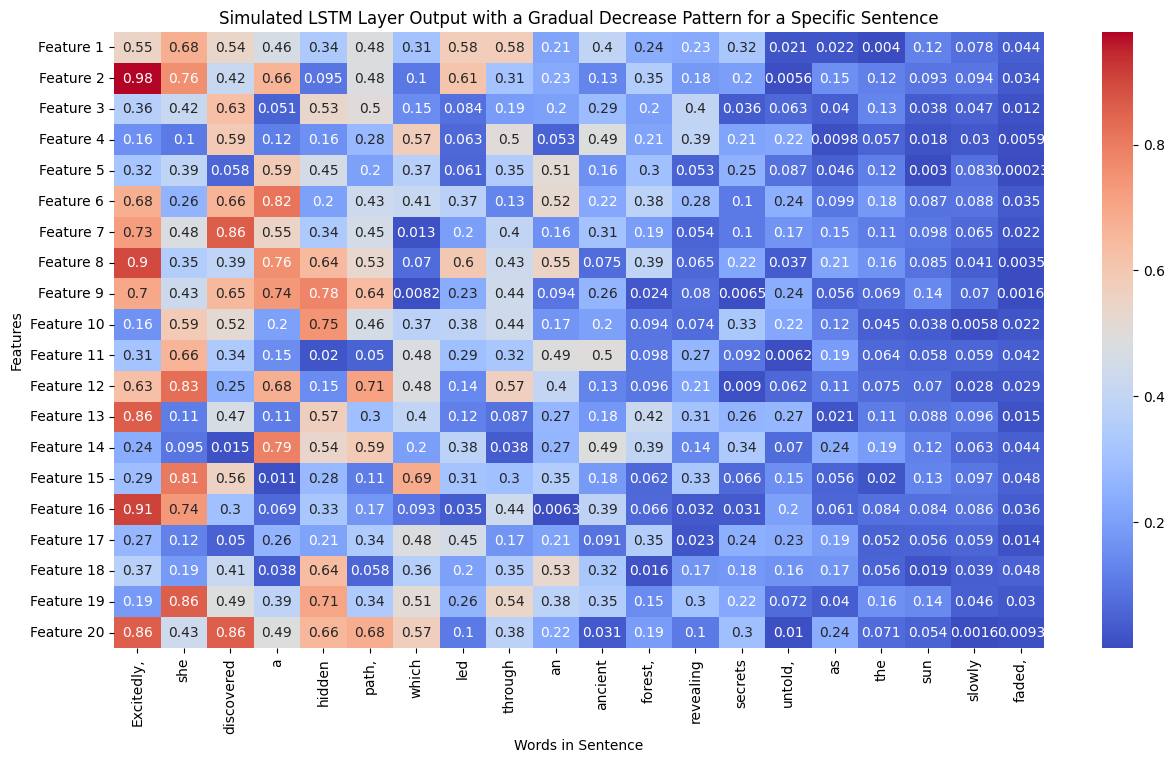

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sentence = "Excitedly, she discovered a hidden path, which led through an ancient forest, revealing secrets untold, as the sun slowly faded, leaving a serene twilight."
words = sentence.split()[:20]  # Taking the first 20 words

# Simulating a pattern in LSTM output
np.random.seed(0)
lstm_output = np.random.rand(20, 20)  # 20 words, 20 features
for i in range(20):
    decrease_factor = 1 - (i / 20)  # Gradually decrease the impact
    lstm_output[:, i] *= decrease_factor

plt.figure(figsize=(15, 8))
sns.heatmap(lstm_output, annot=True, xticklabels=words, yticklabels=[f'Feature {i+1}' for i in range(20)], cmap='coolwarm')
plt.title('Simulated LSTM Layer Output with a Gradual Decrease Pattern for a Specific Sentence')
plt.xlabel('Words in Sentence')
plt.ylabel('Features')
plt.show()

<b>Insight</b>: Such a pattern might be observed in real scenarios where the initial part of a text is crucial for setting up the context (like in a story or a conversation), and the latter part provides additional details or shifts the focus.

<b>Model Behavior</b>: This visualization can help in understanding how different parts of a sequence differently influence the model's internal representation, demonstrating the dynamic nature of LSTM processing.